In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np
from deepface import DeepFace
from ultralytics import YOLO
from numba import jit

In [3]:
@jit
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

@jit
def findEuclideanDistance(source_representation, test_representation):
    if isinstance(source_representation, list):
        source_representation = np.array(source_representation)

    if isinstance(test_representation, list):
        test_representation = np.array(test_representation)

    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance
@jit
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

In [181]:
img1 = cv.imread("dataset/Bill_Gates/Bill_Gates_0015.jpg")
img2 = cv.imread("dataset/Bill_Gates/Bill_Gates_0004.jpg")

In [115]:
detector = YOLO("yolov8n-face.pt")

In [182]:
detections1 = detector(img1, imgsz=640, conf=0.5)
detections2 = detector(img2, imgsz=640, conf=0.5)


0: 640x640 1 face, 62.7ms
Speed: 6.0ms preprocess, 62.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 102.0ms
Speed: 30.0ms preprocess, 102.0ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)


In [183]:
#crop face
boxes = detections1[0].boxes
for box in boxes:
    top_left_x = int(box.xyxy.tolist()[0][0]) 
    top_left_y = int(box.xyxy.tolist()[0][1])
    bottom_right_x = int(box.xyxy.tolist()[0][2])
    bottom_right_y = int(box.xyxy.tolist()[0][3])
    face1 = img1[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
boxes = detections2[0].boxes
for box in boxes:
    top_left_x = int(box.xyxy.tolist()[0][0]) 
    top_left_y = int(box.xyxy.tolist()[0][1])
    bottom_right_x = int(box.xyxy.tolist()[0][2])
    bottom_right_y = int(box.xyxy.tolist()[0][3])
    face2 = img2[top_left_y:bottom_right_y, top_left_x:bottom_right_x]


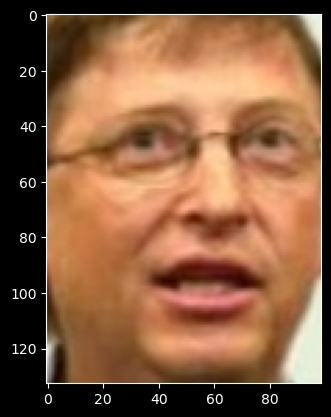

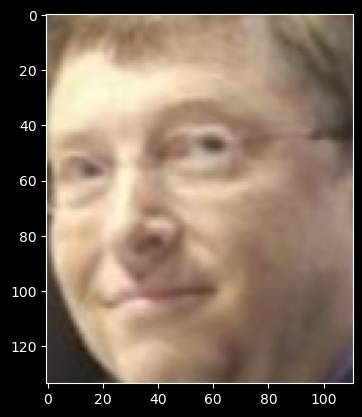

In [184]:
plt.imshow(face1[:,:,::-1])
plt.show()
plt.imshow(face2[:,:,::-1])
plt.show()

In [9]:
# model_name = [
#     "VGG-Face",
#     "Facenet",
#     "Facenet512",
#     "OpenFace",
#     "DeepFace",
#     "ArcFace",
# ]
# for name in model_name:
#     starttime = time.time()
#     DeepFace.represent(face1, model_name=name, detector_backend="skip",enforce_detection=False)
#     print(
#         "Model name: ",
#         name,
#         " Time: ",
#         time.time() - starttime,
#     )

Model name:  VGG-Face  Time:  0.2763078212738037
Model name:  Facenet  Time:  0.11600255966186523
Model name:  Facenet512  Time:  0.11299943923950195
Model name:  OpenFace  Time:  0.07999992370605469
Model name:  DeepFace  Time:  0.11403417587280273
Model name:  ArcFace  Time:  0.16000103950500488


In [201]:
starttime = time.time()
embedding1 = DeepFace.represent(face1, model_name="Facenet", detector_backend="opencv",enforce_detection=False)[0]['embedding']
embedding2 = DeepFace.represent(face2, model_name="Facenet", detector_backend="opencv",enforce_detection=False)[0]['embedding']
print(" Time: ", time.time() - starttime)

 Time:  0.2240002155303955


In [202]:
# calculate distance
distance = findEuclideanDistance(embedding1, embedding2)
print(distance)

12.996360434860767


In [204]:
starttime = time.time()
face1__ = DeepFace.extract_faces(face1,target_size=(160,160), detector_backend="skip",enforce_detection=False)[0]['face']
face2__ = DeepFace.extract_faces(face2,target_size=(160,160), detector_backend="skip",enforce_detection=False)[0]['face']
print(" Time: ", time.time() - starttime)

 Time:  0.0019986629486083984


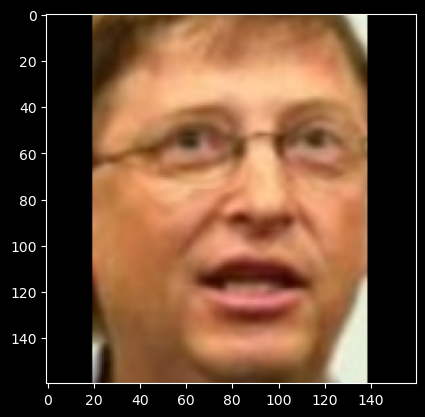

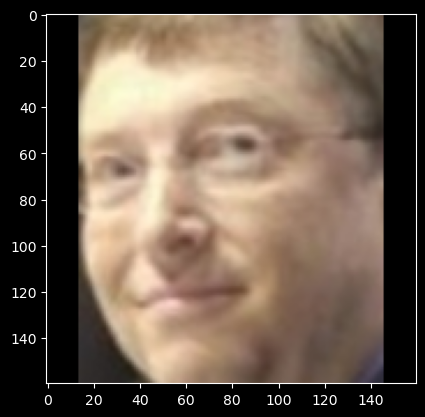

In [205]:
plt.imshow(face1__)
plt.show()
plt.imshow(face2__)
plt.show()

In [209]:
embedding1__ = DeepFace.represent(face1__, model_name="Facenet", detector_backend="skip",enforce_detection=False)[0]['embedding']
embedding2__ = DeepFace.represent(face2__, model_name="Facenet", detector_backend="skip",enforce_detection=False)[0]['embedding']

In [210]:
print(findEuclideanDistance(embedding1__, embedding2__))

11.725336696382284


In [211]:
DeepFace.verify(face1, face2, model_name="Facenet", detector_backend="skip",enforce_detection=False,distance_metric='euclidean')

{'verified': False,
 'distance': 12.996360434860765,
 'threshold': 10,
 'model': 'Facenet',
 'detector_backend': 'skip',
 'similarity_metric': 'euclidean',
 'facial_areas': {'img1': {'x': 0, 'y': 0, 'w': 99, 'h': 133},
  'img2': {'x': 0, 'y': 0, 'w': 111, 'h': 134}},
 'time': 0.2}

In [243]:
DeepFace.verify(img1, img2, model_name="Facenet", detector_backend="skip",enforce_detection=False,distance_metric='euclidean')

{'verified': True,
 'distance': 8.278526717609038,
 'threshold': 10,
 'model': 'Facenet',
 'detector_backend': 'skip',
 'similarity_metric': 'euclidean',
 'facial_areas': {'img1': {'x': 0, 'y': 0, 'w': 250, 'h': 250},
  'img2': {'x': 0, 'y': 0, 'w': 250, 'h': 250}},
 'time': 0.21}

In [239]:
embedding11 = DeepFace.represent(img1, model_name="Facenet", detector_backend="skip",enforce_detection=False)[0]['embedding']
embedding21 = DeepFace.represent(img2, model_name="Facenet", detector_backend="skip",enforce_detection=False)[0]['embedding']

In [240]:
print(findEuclideanDistance(embedding11, embedding21))

13.519769445447336
